In [1]:
!unzip /kaggle/input/covid19-pneumonia-and-normal-chest-xray-dataset/898720e7-9fcd-49f0-87ba-08c979e6f35e

Archive:  /kaggle/input/covid19-pneumonia-and-normal-chest-xray-dataset/898720e7-9fcd-49f0-87ba-08c979e6f35e
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/0C7E78DA-FAFC-480D-88B6-1459C51481AF-1068x817.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6-1068x1086.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/134895D3-77B8-4546-B7E5-C7DABD600309-1068x911.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D-768x635.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/1F6343EE-AFEC-4B7D-97F5-62797EE18767-1068x1064.jpeg  
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Datas

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import random

import seaborn as sns
sns.set_theme(style="whitegrid", palette="Set2")

# Data Visualization

In [3]:
# maake a dataframe with filepath and labels
def make_path_label_df(imgpath):
    dir = Path(imgpath)
    filepaths = list(dir.glob(r'**/*.*'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='filepath').astype(str)
    labels = pd.Series(labels, name='label')

    df_big = pd.concat([filepaths , labels] , axis=1)
    return df_big
    
df_big = make_path_label_df("/kaggle/working/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset")
df_big.head()

,filepath,label
0,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid
1,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid
2,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid
3,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid
4,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid


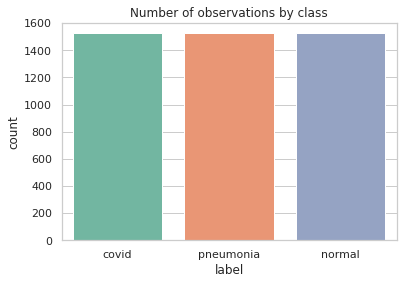

In [4]:
sns.countplot(x=df_big.label)
plt.title("Number of observations by class");

The dataset is balanced.

In [5]:
def plot_random_images(df):
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 6))
        for i in range(6):
            plt.subplot(2, 3, i + 1)
            idx = random.randint(0, len(df['label']))
            path = df['filepath'].iloc[idx]
            img = mpimg.imread(path)
            plt.imshow(img, cmap='bone')
            plt.title(df['label'].iloc[idx])

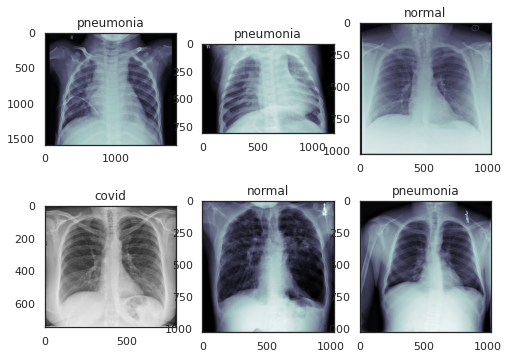

In [6]:
random.seed(5)
plot_random_images(df_big)

We can see several issues with these images:
1. They are different size, so we need to bring them to the same size.
2. Some of them are 3 chanel RGB photos, while others are 1 chanel grayscale. We need to make all of them grayscale.
3. COVID images are sometimes flipped or rotated.
4. The images have different width to height ratio. We can see that pneumonia class is wider that others, so let's check the average width to height ratio by class.

In [7]:
def calculate_ratio(path):
    img = mpimg.imread(path)
    ratio = img.shape[1] / img.shape[0]
    return ratio

df_big['ratio'] = df_big['filepath'].apply(lambda x: calculate_ratio(x))
df_big.head()

,filepath,label,ratio
0,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid,1.000000
1,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid,1.000000
2,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid,1.000000
3,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid,1.345679
4,/kaggle/working/COVID19_Pneumonia_Normal_Chest...,covid,1.000000


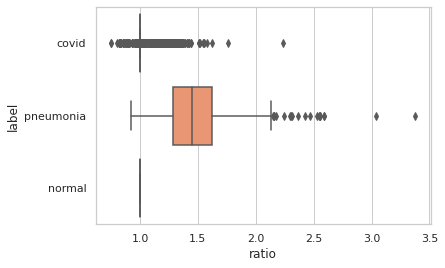

In [8]:
sns.boxplot(data=df_big, x='ratio', y='label');

We can see that on avarage, the width to height ratio for pneumonia is significantly larger than for covid and normal labels. For the normal class, all the images are the same size.
Thus, we will apply the following 2 techniqes:
1. Scale all the images to make them square.
2. Pad the rectangular images to make them square.

# Data Preprocessing

## Scale the rectangular images

In [9]:
def resize_images(df, save_folder, size=(224, 224), extenstion='png'):
    for i in range(len(df['filepath'])):
        path = df['filepath'][i]
        label = df['label'][i]
        file_name = path.split('/')[5].replace('.', '_')

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        
        file_name = f"{save_folder}/{label}/{file_name}.{extenstion}"
        cv2.imwrite(file_name, img.astype(np.uint8))
        img2 = mpimg.imread(file_name)

In [10]:
SAVE_FOLDER = "resized_dataset"
SIZE = (224, 224)

for label in df_big.label.unique():
    os.makedirs(SAVE_FOLDER+'/'+label, exist_ok=True)
    
resize_images(df_big, SAVE_FOLDER, size=SIZE)

In [11]:
df_scale = make_path_label_df('/kaggle/working/resized_dataset')

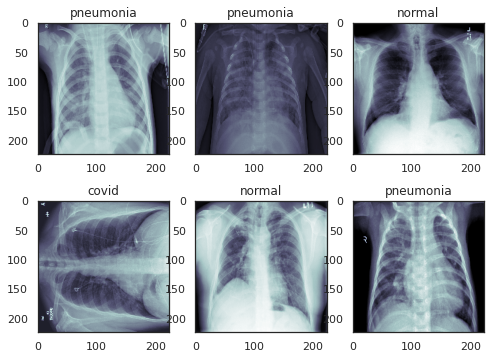

In [12]:
random.seed(5)
plot_random_images(df_scale)

## Pad the rectangular images

In [13]:
def resize_with_padding(df, save_folder, size=(224, 224), extenstion='png'):
    for i in range(len(df['filepath'])):
        path = df['filepath'][i]
        label = df['label'][i]
        file_name = path.split('/')[5].replace('.', '_')

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        # add zeros to the narrow parts of the image
        height = img.shape[0]
        width = img.shape[1]
        if width > height:
            add_up = (width - height) // 2
            add_bottom = width - height - add_up
            add_left = 0
            add_right = 0
            img = cv2.copyMakeBorder(img, add_up, add_bottom, add_left, add_right, cv2.BORDER_CONSTANT, None, value = 0)
        elif width < height:
            add_up = 0
            add_bottom = 0
            add_left = (height - width) // 2
            add_right = height - width - add_up
            img = cv2.copyMakeBorder(img, add_up, add_bottom, add_left, add_right, cv2.BORDER_CONSTANT, None, value = 0)
        
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(f"{save_folder}/{label}/{file_name}.{extenstion}", img.astype(np.uint8))

In [14]:
SAVE_FOLDER = 'resized_with_padding'
SIZE = (224, 224)

for label in df_big.label.unique():
    os.makedirs(SAVE_FOLDER+'/'+label, exist_ok=True)
    
resize_with_padding(df_big, SAVE_FOLDER, size=SIZE)

In [15]:
df_pad = make_path_label_df('resized_with_padding')

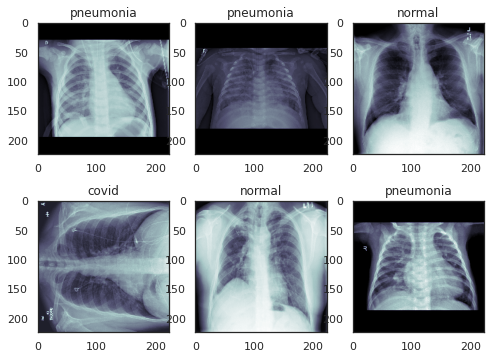

In [16]:
random.seed(5)
plot_random_images(df_pad)

In [17]:
!rm -r COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset